In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Initialisation
#### Xavier initialization for weights
![](images/c1.jpg)
#### Biases: Initialized to zeros


###  Forward Propagation
##### ![](images/c2.jpg)
##### ![](images/c3.jpg)

##### ![](images/c4.jpg)
###### Where: xi is the output of the i-th neuron in the last layer

### Loss function
##### ![](images/c5.jpg)
###### Where: N is the number of samples in the batch
###### y_pred[i,y true[i]] is the predicted probability for the correct class 
###### ϵ is a small value added for numerical stability

### Backpropagation
Output Layer Gradients
##### ![](images/c6.jpg)
Hidden Layer Gradients
##### ![](images/c7.jpg)
Weight and Bias Gradients
##### ![](images/c8.jpg)      ![](images/c9.jpg)

###### δ[l] is the error at the output layer 
###### W[l+1]  is the weight matrix of the next layer
###### ReLU'(z[l]) is 1 if z> 0 else 0


### Parameter Update
##### ![](images/c10.jpg)
##### ![](images/c11.jpg)

###### η is the learning rate

In [2]:
class Neural_Net():
    def __init__(self, layers):
        self.layers = layers  # layers = [input_size, hidden_size, output_size]
        self.number_of_layers = len(layers)
        # Initialize the weights randomly with a uniform distribution
        self.weights = [
            np.random.uniform(-np.sqrt(6 / (layers[i] + layers[i + 1])),
                              np.sqrt(6 / (layers[i] + layers[i + 1])),
                              size=(layers[i], layers[i + 1]))
            for i in range(len(layers) - 1)
        ]
        # Initialize biases as zeros for each layer
        self.biases = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]


    def forward_pass(self, out):
        for w, b in zip(self.weights, self.biases):
            out = np.dot(out, w)+b # out = sum(x.w) + b
        return self.relu(out) # Apply ReLU activation function to the output


    

    def relu(self, x):
        return np.maximum(0, x)

    def derivative_relu(self, x):
        return np.where(x > 0, 1, 0) # Return 1 if input is positive, else 0

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


    def sparse_categorical_crossentropy(self, y_pred, y_true, lambda_reg=0.01):
        probs = y_pred[np.arange(len(y_true)), y_true]
        loss = -np.mean(np.log(probs + 1e-15))
        # Regularisation L2
        reg_loss = 0
        for w in self.weights:
            reg_loss += np.sum(w ** 2)
        loss += lambda_reg * reg_loss
        return loss


    def forward_back_propagation(self, x, y):
        # Perform both forward and backward passes (training step)
        # Step 1: Forward pass
        activations = [x]  # Store activations
        z_values = []  # Store pre-activation values
        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            z_values.append(z)
            activations.append(self.relu(z))  # Apply ReLU activation
        
        # Output layer activation with softmax
        y_pred = self.softmax(z_values[-1])
        loss = self.sparse_categorical_crossentropy(y_pred, y)

        # Step 2: Backward pass
        delta_w = [np.zeros_like(w) for w in self.weights]
        delta_b = [np.zeros_like(b) for b in self.biases]

        # Output layer error
        delta = y_pred
        delta[np.arange(len(y)), y] -= 1  # Gradient of softmax + cross-entropy
        delta /= len(y)  # Average over batch size
        
        # Compute gradients for output layer
        delta_b[-1] = np.sum(delta, axis=0, keepdims=True)
        delta_w[-1] = np.dot(activations[-2].T, delta)

        # Backpropagation through hidden layers
        for l in range(2, self.number_of_layers):
            delta = np.dot(delta, self.weights[-l + 1].T) * self.derivative_relu(z_values[-l])
            delta_b[-l] = np.sum(delta, axis=0, keepdims=True)
            delta_w[-l] = np.dot(activations[-l - 1].T, delta)

        return loss, delta_w, delta_b

    def update_parameters(self, lr, delta_weights, delta_biases):
        # Update the weights and biases using the computed gradients and learning rate
        self.weights = [w - lr * dw for w, dw in zip(self.weights, delta_weights)]
        self.biases = [b - lr * db for b, db in zip(self.biases, delta_biases)]

    def test_and_display_results(self, test_data):
        x_batch, y_batch = zip(*test_data)  
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        # Perform a forward pass on the test data to get predictions
        y_pred = self.forward_pass(x_batch)  
        predicted_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
    
        # Calculate the number of correctly classified examples
        correct_predictions = np.sum(predicted_labels == y_batch)
    
        # Calculate accuracy as a percentage of correct predictions
        accuracy = (correct_predictions / len(y_batch)) * 100
    
        # Display the accuracy
        print(f"Accuracy: {accuracy:.2f}%")
    
        # Display the true and predicted labels for each test example
        for true_label, predicted_label in zip(y_batch, predicted_labels):
            print(f"True Label: {true_label}, Predicted Label: {predicted_label}")



    def main(self, train_data, val_data, epochs, mini_batch_size, lr):
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training phase
            np.random.shuffle(train_data)
            mini_batches = [train_data[k:k + mini_batch_size] for k in range(0, len(train_data), mini_batch_size)]

            for mini_batch in mini_batches:
                x_batch, y_batch = zip(*mini_batch)
                x_batch = np.array(x_batch)
                y_batch = np.array(y_batch)

                # Perform forward and backward propagation, then update parameters
                train_loss, delta_weights, delta_biases = self.forward_back_propagation(x_batch, y_batch)
                self.update_parameters(lr, delta_weights, delta_biases)

            train_losses.append(np.mean(train_loss))

            # Validation phase
            x_val, y_val = zip(*val_data)
            x_val = np.array(x_val)
            y_val = np.array(y_val)

            val_pred = self.forward_pass(x_val)  # Perform a forward pass to get predictions
            val_loss = self.sparse_categorical_crossentropy(val_pred, y_val)
            val_losses.append(np.mean(val_loss)) # Store the average validation loss for the epoch

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        return train_losses, val_losses



In [3]:
data = pd.read_pickle("data.pkl")
data.head()

,0,1,2,3,4,5,6,7,8,9,...,155,156,157,158,159,160,161,162,163,classe
0,-1.972984,-0.662457,-2.050522,-9.940406,1.092102,13.248902,1.042499,1.356317,-3.859444,1.451024,...,-0.094110,-0.070467,0.043868,-0.010685,0.162154,0.060055,0.085598,0.067697,0.060320,1
1,-0.886763,-6.294663,-0.982611,-12.045291,-8.364764,9.788482,-8.169029,5.438308,-4.287798,3.272946,...,0.368285,0.102426,0.178326,-0.028675,-0.016342,0.011003,0.084225,0.164539,-0.200603,2
2,-2.942329,4.044668,-3.355798,-7.157855,14.026085,7.046022,1.324236,-0.430195,-0.021683,6.383509,...,0.190772,0.088811,0.220909,-0.302500,-0.016314,-0.115783,0.240808,-0.343816,0.116286,1
3,0.443608,-13.526142,-1.887917,-17.283374,-7.929551,8.560559,-7.266135,2.906087,0.121871,1.513187,...,0.188207,0.373746,-0.416464,-0.443712,-0.286822,-0.363242,0.130634,0.279820,0.144384,2
4,-2.550021,4.679707,-0.781664,-2.560824,0.278584,10.391701,6.171435,-1.404094,-4.478779,-4.772164,...,-0.057184,0.006213,-0.472880,0.103305,-0.054400,-0.227108,-0.021183,-0.082541,0.188614,1


In [4]:
# gets data and splits it into features and target
X = data.iloc[:, :-1].values 
Y = data.iloc[:, -1].values

In [5]:
# Créer un array de tuples
data_tuples = list(zip(X, Y))

# Diviser les données en jeu d'entraînement, validation et test (70/15/15)
train_data, test_data = train_test_split(data_tuples, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [6]:
# Conversion des étiquettes en entiers
train_data = [(x, int(y)) for x, y in train_data]
test_data = [(x, int(y)) for x, y in test_data]
val_data = [(x, int(y)) for x, y in val_data]
test_data = [(x, int(y)) for x, y in test_data]

### Training Process

#### Network Architecture 
##### Layers: [input_size, hidden_size, output_size] corresponds to :
##### 164 input features, 115 hidden neurons, and 3 output classes


#### Hyperparameters
##### Epochs: 300
##### Mini-batch size: 100
##### Learning rate: 0.001


##### The data is split into mini-batches to train the network incrementally
##### Losses for training and validation are recorded for each epoch

In [23]:
# Initialisation of the neural network 
layers = [164, 115, 3]   
nn = Neural_Net(layers)


epochs = 300
mini_batch_size = 100
lr = 0.0001

In [24]:
# Traning and validation phase
train_losses, val_losses = nn.main(train_data, val_data, epochs, mini_batch_size, lr)

Epoch 1/300, Train Loss: 4.0255, Val Loss: 18.8652
Epoch 2/300, Train Loss: 4.0912, Val Loss: 18.7550
Epoch 3/300, Train Loss: 3.3039, Val Loss: 19.0551
Epoch 4/300, Train Loss: 3.9559, Val Loss: 19.1511
Epoch 5/300, Train Loss: 3.3086, Val Loss: 19.1497
Epoch 6/300, Train Loss: 3.2962, Val Loss: 19.0384
Epoch 7/300, Train Loss: 3.5889, Val Loss: 18.8153
Epoch 8/300, Train Loss: 3.0371, Val Loss: 18.5950
Epoch 9/300, Train Loss: 3.6371, Val Loss: 18.4751
Epoch 10/300, Train Loss: 3.6116, Val Loss: 18.4504
Epoch 11/300, Train Loss: 3.5193, Val Loss: 18.4377
Epoch 12/300, Train Loss: 3.6300, Val Loss: 18.3245
Epoch 13/300, Train Loss: 3.6818, Val Loss: 18.3160
Epoch 14/300, Train Loss: 3.2275, Val Loss: 18.4174
Epoch 15/300, Train Loss: 3.3427, Val Loss: 18.4157
Epoch 16/300, Train Loss: 3.1946, Val Loss: 18.4057
Epoch 17/300, Train Loss: 3.1964, Val Loss: 18.4023
Epoch 18/300, Train Loss: 3.4742, Val Loss: 18.2938
Epoch 19/300, Train Loss: 2.8237, Val Loss: 18.2833
Epoch 20/300, Train L

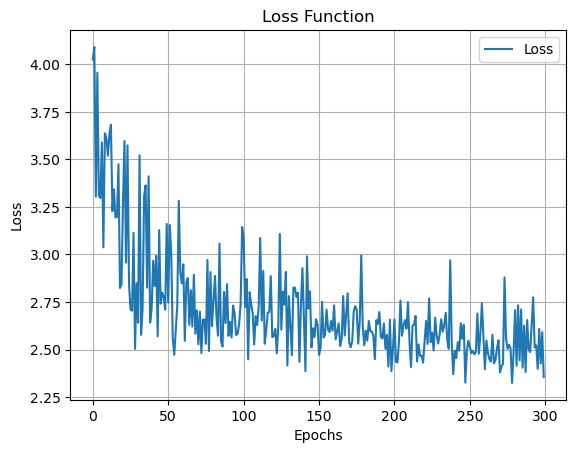

In [25]:
# Plotting the loss function
plt.plot(train_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.grid(True)
plt.show()


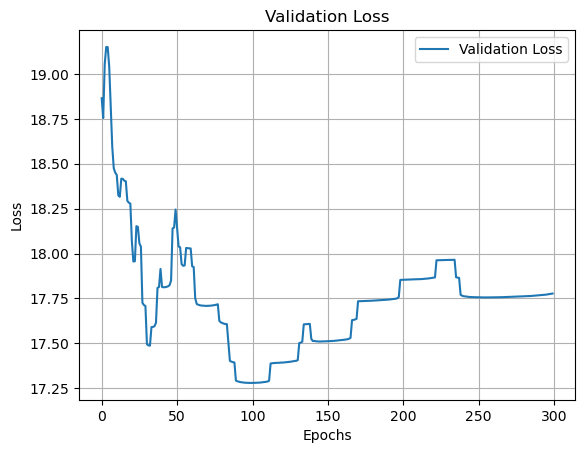

In [26]:
# Plotting the validation loss
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

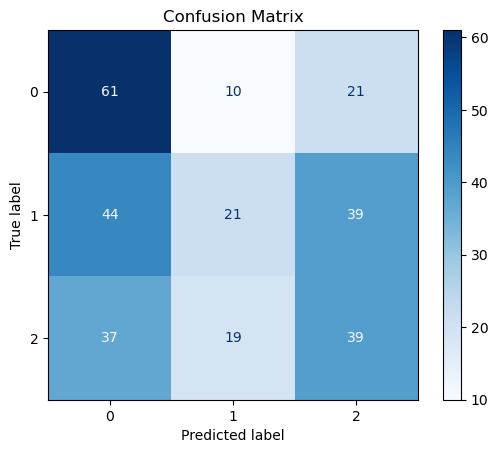

In [31]:
# Generate predictions for the test set
x_test, y_test = zip(*test_data) 
x_test = np.array(x_test)
y_test = np.array(y_test)

y_pred = nn.forward_pass(x_test)  # Perform a forward pass on the test data
predicted_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to labels

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Confusion Matrix")
plt.show()


In [28]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision, recall, and F1-score (macro average)
precision = precision_score(y_test, predicted_labels, average='macro')
recall = recall_score(y_test, predicted_labels, average='macro')
f1 = f1_score(y_test, predicted_labels, average='macro')

# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro): {precision:.2f}")
print(f"Recall (Macro): {recall:.2f}")
print(f"F1-Score (Macro): {f1:.2f}")


Accuracy: 0.42
Precision (Macro): 0.41
Recall (Macro): 0.43
F1-Score (Macro): 0.40


### Testing


In [30]:
test = nn.test_and_display_results(test_data)

Accuracy: 41.58%
True Label: 1, Predicted Label: 1
True Label: 1, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 1, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 0
True Label: 2, Predicted Label: 2
True Label: 2, Predicted Label: 1
True Label: 2, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 2, Predicted Label: 0
True Label: 0, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 2
True Label: 0, Predicted Label: 1
True Label: 1, Predicted Label: 2
True Label: 0, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 2, Predicted Label: 0
True Label: 1, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 1, Predicted Label: 2
True Label: 0, Predicted Label: 1
True Label: 2, Predicted Label: 2
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 2
True Label: 2, Predicted Label: